<a href="https://colab.research.google.com/github/Evgeniya371/PRA3024/blob/main/Homework_2_(Gravitaional_Waves)%2C_PRA3024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
!{sys.executable} -m pip install pycbc ligo-common --no-cache-dir 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 KB 94.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 148.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 KB 97.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 49.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 KB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.waveform import get_fd_waveform
from pycbc.psd import welch, interpolate
from pycbc.catalog import Merger
import pylab
from pycbc.types import  FrequencySeries, TimeSeries
import numpy as np
from pycbc import frame
import pycbc
from pycbc.filter import resample_to_delta_t, highpass
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm 
from pycbc.detector import Detector
from scipy.interpolate import interp1d

import numpy as np



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Matched filter
# Part 1: Load the data

d = np.load('/content/drive/MyDrive/GW_noisedata-2.npy') #name of the data file GW_noisedata-2.npy
dt = d[:, 0] #select column '0' - time column

# H1(column '1') and L1(column '2') correspond to Hanford and Livingston data respectively
data_H1 = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0]) #this is to convert data into GW timeSeries, delta_t is a time interval
data_L1 = pycbc.types.TimeSeries(d[:, 2], delta_t = dt[1]- dt[0]) #this is to convert data into GW timeSeries, delta_t is a ime interval
merger = Merger("GW170817")
strain, stilde = {}, {}  #create strain and stilde dictionaries

# Apply the highpass filter and downsample the data at a sampling rate of 2048Hz
strain['H1'] = resample_to_delta_t(highpass(data_H1, 15.0), 1.0/2048)  
strain['L1'] = resample_to_delta_t(highpass(data_L1, 15.0), 1.0/2048)

# Crop the data in order to prevent it from being wraped around at the boundaries
strain['H1'] = strain['H1'].crop(4, 4)
strain['L1'] = strain['L1'].crop(4, 4)

#transform timeseries to frequency domain
stilde['H1'] = strain['H1'].to_frequencyseries()
stilde['L1'] = strain['L1'].to_frequencyseries()


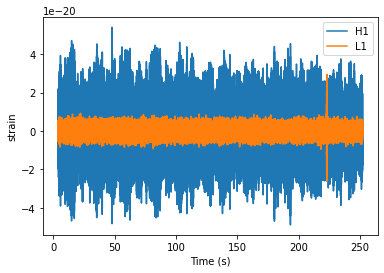

In [ ]:
# This cell prints time-series data (strain.delta_t)

pylab.plot(strain['H1'].sample_times, strain['H1'], label= 'H1')
pylab.plot(strain['L1'].sample_times, strain['L1'], label= 'L1')
pylab.legend()
pylab.xlabel('Time (s)')
pylab.ylabel('strain')
pylab.show()


/usr/local/lib/python3.9/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


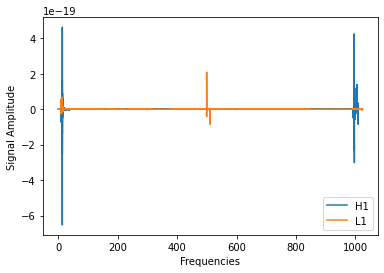

In [ ]:
# This cell prints frequecncy components of the data (strain.delta_t)

pylab.plot(stilde['H1'].sample_frequencies, stilde['H1'], label= 'H1')
pylab.plot(stilde['L1'].sample_frequencies, stilde['L1'], label= 'L1')
pylab.legend()
pylab.xlabel('Frequencies')
pylab.ylabel('Signal Amplitude')
pylab.show()


In [5]:
# Part 1
# For this part the following source was used: https://github.com/gwastro/PyCBC-Tutorials/blob/master/tutorial/3_WaveformMatchedFilter.ipynb
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.waveform import get_td_waveform

# List of td approximants thsqat are currently available
print(td_approximants())

['TaylorT1', 'TaylorT2', 'TaylorT3', 'SpinTaylorT1', 'SpinTaylorT4', 'SpinTaylorT5', 'PhenSpinTaylor', 'PhenSpinTaylorRD', 'EOBNRv2', 'EOBNRv2HM', 'TEOBResum_ROM', 'SEOBNRv1', 'SEOBNRv2', 'SEOBNRv2_opt', 'SEOBNRv3', 'SEOBNRv3_pert', 'SEOBNRv3_opt', 'SEOBNRv3_opt_rk4', 'SEOBNRv4', 'SEOBNRv4_opt', 'SEOBNRv4P', 'SEOBNRv4PHM', 'SEOBNRv2T', 'SEOBNRv4T', 'SEOBNRv4_ROM_NRTidalv2', 'SEOBNRv4_ROM_NRTidalv2_NSBH', 'HGimri', 'IMRPhenomA', 'IMRPhenomB', 'IMRPhenomC', 'IMRPhenomD', 'IMRPhenomD_NRTidalv2', 'IMRPhenomNSBH', 'IMRPhenomHM', 'IMRPhenomPv2', 'IMRPhenomPv2_NRTidal', 'IMRPhenomPv2_NRTidalv2', 'TaylorEt', 'TaylorT4', 'EccentricTD', 'SpinDominatedWf', 'NR_hdf5', 'NRSur7dq2', 'NRSur7dq4', 'SEOBNRv4HM', 'NRHybSur3dq8', 'IMRPhenomXAS', 'IMRPhenomXHM', 'IMRPhenomPv3', 'IMRPhenomPv3HM', 'IMRPhenomXP', 'IMRPhenomXPHM', 'TEOBResumS', 'IMRPhenomT', 'IMRPhenomTHM', 'IMRPhenomTP', 'IMRPhenomTPHM', 'TaylorF2', 'SEOBNRv1_ROM_EffectiveSpin', 'SEOBNRv1_ROM_DoubleSpin', 'SEOBNRv2_ROM_EffectiveSpin', 'SEOBN

In [6]:


# This function calculates the matched filter between the given data and a template waveform
from pycbc.filter import matched_filter

def compute_snr(template, data, psd, low_frequency_cutoff=20):
# template  – the template waveform (K(t) filter)
# data  – the strain data to be filtered.
# psd – the power spectral density
# low_frequency_cutoff – the frequency to begin the filter calculation


      snr = matched_filter(template, data, psd=psd, low_frequency_cutoff=20)

      # Trim the ends of the data after filtering
      snr = snr.crop(4 + 4, 4)
      return snr



In [7]:
# This function computes power spectral density (PSD) of the data in order to weight the noise 
import pycbc.psd
def compute_psd(data, data_fd):
      # data - timeseris data
      # data_fd - frequency domain data
      # delta_t - time interval
      
      delta_t = data.delta_t # sampling time 
      seg_len = int(2 / delta_t)    # segment length
      seg_stride = int(seg_len / 2) # separation between consecutive segments
    
      # Apply PSD estimator based on Welch’s method:
      PSD = pycbc.psd.welch(data,  # power specrum density (estimate psd from every chunk and then overlap them)
                      seg_len=seg_len,
                      seg_stride=seg_stride)
      PSD = interpolate(PSD, data_fd.delta_f)
      return PSD

In [8]:


# This function generates the template waveforms for matched filtering using 'TaylorT2' approximation

def get_template(m, data, approximant):

    hp, hc = get_td_waveform(approximant=approximant,
                         mass1=m,
                         mass2=m,
                         delta_t=data.delta_t,
                         f_lower=30) #the starting frequency of the waveform (in Hz)
    
    # Resize the vector to match our data
    hp.resize(len(data))
    template = hp.cyclic_time_shift(hp.start_time)
    return template


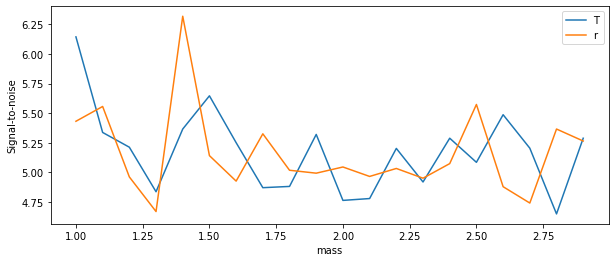

In [9]:
# Generate the template waveforms for matched filtering using 'TaylorT2' approximation

# I computed SNR for H1 data
masses = np.arange(1.0, 3.0,0.10).tolist() # Mass range bewteen 1 to 3 Solar masses, 0.1 is a step
data_H1=strain['H1']
data_fd_H1=stilde['H1']
data_L1=strain['L1']
data_fd_L1=stilde['L1']
snr_list_H1=[]
snr_list_L1=[]
delta_t=dt[1]- dt[0]
dict_masses_H1={}  # This dictionary stores SNR values corresponding to Solar masses from the given range (H1 data)
dict_masses_L1={}  # This dictionary stores SNR values corresponding to Solar masses from the given range (L1 data)

for m in masses:
  
  template=get_template(m, data_H1, approximant="TaylorT2")
  psd=compute_psd(data_H1, data_fd_H1)
  snr=compute_snr(template, data_H1, psd, low_frequency_cutoff=20)
  snr_list_H1.append(max(abs(snr)))
  dict_masses_H1[m]=max(abs(snr))
  

for m in masses:
  
  template=get_template(m, data_L1, approximant="TaylorT2")
  psd=compute_psd(data_L1, data_fd_L1)
  snr=compute_snr(template, data_L1, psd, low_frequency_cutoff=20)
  snr_list_L1.append(max(abs(snr)))
  dict_masses_L1[m]=max(abs(snr))



pylab.figure(figsize=[10, 4])
pylab.plot(masses, snr_list_H1, label= 'H1')
pylab.plot(masses, snr_list_L1, label= 'L1')
pylab.legend('True')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

In [ ]:
print(dict_masses_H1) # Show the example of dictionary storing SNR values

{1.0: 6.144333738652498, 1.1: 5.336437355240374, 1.2000000000000002: 5.211686170074834, 1.3000000000000003: 4.835255427651724, 1.4000000000000004: 5.365233023812611, 1.5000000000000004: 5.646059773293764, 1.6000000000000005: 5.250034305892325, 1.7000000000000006: 4.869516173434369, 1.8000000000000007: 4.880088098460328, 1.9000000000000008: 5.319656637942399, 2.000000000000001: 4.761966169321571, 2.100000000000001: 4.777619883727018, 2.200000000000001: 5.201425408269832, 2.300000000000001: 4.917689901696531, 2.4000000000000012: 5.287723995553432, 2.5000000000000013: 5.083959691501981, 2.6000000000000014: 5.486363446824654, 2.7000000000000015: 5.203387597995891, 2.8000000000000016: 4.647702529762347, 2.9000000000000017: 5.287644873676939}


In [10]:
# From: https://www.geeksforgeeks.org/python-get-key-from-value-in-dictionary/

# This function gets key corresponding to a value
def get_key_from_value(d, val):
    keys = [k for k, v in d.items() if v == val]
    if keys:
        return keys[0]
    return None

In [12]:
# Take an abs() to account for the fact that matched_filter outputs a complex snr 
# argmax() function returns indices of the max element of the array in a particular axis

peak_H1 = max(snr_list_H1)
optimal_mass = get_key_from_value(dict_masses_H1, peak_H1) # Find the template waveform for which snr is max
print("H1 detector data. The optimal mass for a template was found to be {:.2f} (in Solar masses)".format(optimal_mass))

peak_L1 = max(snr_list_L1)
optimal_mass = get_key_from_value(dict_masses_L1, peak_L1) # Find the template waveform for which snr is max
print("L1 detector data. The optimal mass for a template was found to be {:.2f} (in Solar masses)".format(optimal_mass))

H1 detector data. The optimal mass for a template was found to be 1.00 (in Solar masses)
L1 detector data. The optimal mass for a template was found to be 1.40 (in Solar masses)


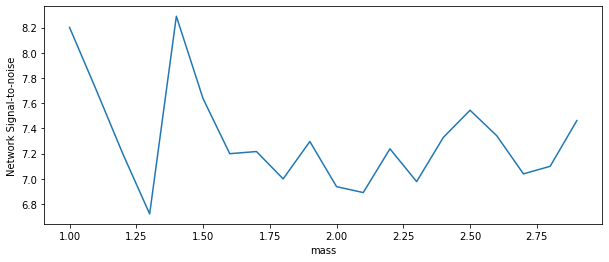

We found the best Mass1=Mass2 was 1.40 solar masses (H1 and L1 detector network)


In [13]:
# Find the mass maximizing SNR for the network of detectotrs
network_snr = (np.array(snr_list_H1)**2 + np.array(snr_list_L1)**2)**0.5
index = np.where(network_snr == max(network_snr))
masses = np.arange(1.0, 3.0, 0.10)
pylab.figure(figsize=[10, 4])
pylab.plot(masses, network_snr)

pylab.ylabel('Network Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

print("We found the best Mass1=Mass2 was %2.2f solar masses (H1 and L1 detector network)" % masses[index])

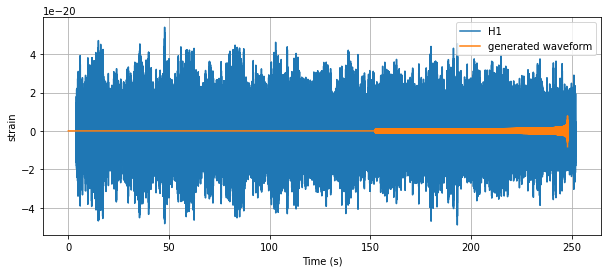

In [ ]:
# Now we can plot the template waveform producing the highest SNR over the data. As we can see, there is no obvious match. It is because our data contains a lot of noise, so we still have to preprocess both the template and data.
data=strain['H1']
template=get_template(1.0, data, approximant="TaylorT2")
pylab.figure(figsize=[10, 4])
pylab.plot(data.sample_times, data, label= 'H1')
pylab.plot(template.sample_times, template, label= 'generated waveform')
pylab.legend()
pylab.xlabel('Time (s)')
pylab.ylabel('strain')
pylab.legend()
pylab.grid()
pylab.show()

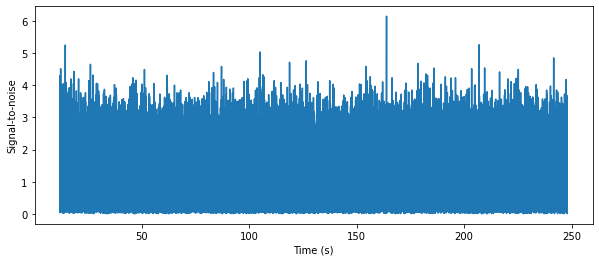

We found a signal at 163.9423828125s with SNR 6.144333738652498


In [14]:
# This cell find the maximum SNR

conditioned=strain['H1']
data_fd=stilde['H1']
template=get_template(1.0, conditioned, approximant="TaylorT2") # We input mass=1.0 (in Solar massses)
psd=compute_psd(conditioned, data_fd)
snr=compute_snr(template, conditioned, psd, low_frequency_cutoff=20)
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

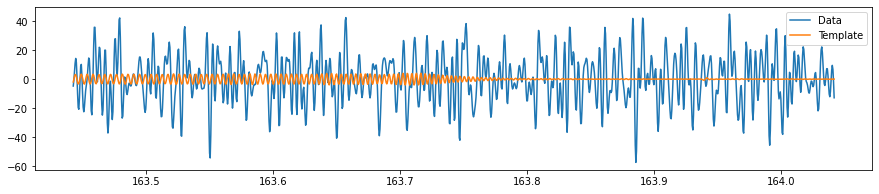

In [19]:


# Fit the best match template waveform against the data

from pycbc.filter import sigma

conditioned=strain['H1']
data_fd=stilde['H1']
template=get_template(1.0, conditioned, approximant="TaylorT2") # We input mass=1.0 (in Solar massses)
psd=compute_psd(conditioned, data_fd)
snr=compute_snr(template, conditioned, psd, low_frequency_cutoff=20)
peak = abs(snr).numpy().argmax() # argmax() funciton find the index of the max value in the array
snrp = snr[peak] # Peak value of the computed SNR
time = snr.sample_times[peak] # Find the time point at which peak SNR is found

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# Scale the template so that it would have SNR 1 in this data
# sigma() function returns the sigma of the waveform
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(30, 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

white_data = white_data.time_slice(time-0.5, time+.1)
white_template = white_template.time_slice(time-0.5,time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

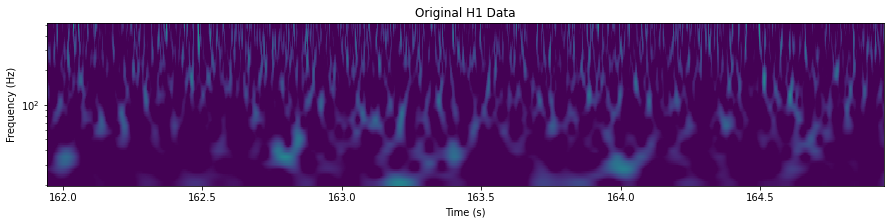

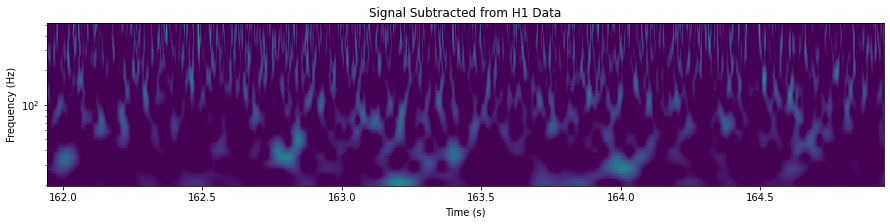

In [21]:
# Chirp structure of the signal over the time-frequency domain using G-transfromation()

subtracted = conditioned - aligned

for data, title in [(conditioned,'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,                # qtransform 
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(time - 2, time + 1)
    pylab.show()

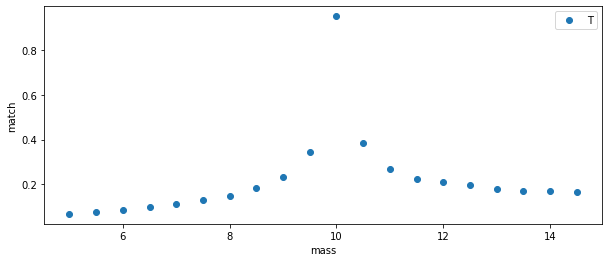

In [26]:
# Part 1.3 

from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower

masses = np.arange(5.0, 15.0, 0.5).tolist() # Mass range bewteen 5 to 15 Solar masses, 1 is a step
f_low = 30
sample_rate = 4096
# Generate the two waveforms to compare
hp, hc = get_td_waveform(approximant = "EOBNRv2", mass1 = 10, mass2 = 10, f_lower = f_low, delta_t = 1.0/sample_rate)
match_list=[]
dict_masses={}

for mass in masses: # Create a template for every mass from the given range (5-15 Solar masses)
   sp, sc = get_td_waveform(approximant = "TaylorT4", mass1 = mass, mass2 = mass, f_lower = f_low, delta_t = 1.0 / sample_rate)

   # Resize the waveforms to the same length
   tlen = max ( len (sp), len (hp))
   sp . resize(tlen)
   hp . resize(tlen)

   # Generate the aLIGO ZDHP PSD
   delta_f = 1.0 / sp . duration
   flen = tlen //2 + 1
   psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
   # Note: This takes a while the first time as an FFT plan is generated
   # subsequent calls are much faster.
   m, i = match(hp, sp, psd = psd, low_frequency_cutoff = f_low)
   match_list.append(m)
   dict_masses[mass]=m

pylab.figure(figsize=[10, 4])
pylab.plot(masses, match_list, 'o')
pylab.legend('True')
pylab.ylabel('match')
pylab.xlabel('mass')
pylab.show()






  


In [27]:
# The match is maximum when mass is equal to 10 Solar masses

In [ ]:
# Detector noise
# Part 2: Load the data

d = np.load('/content/drive/MyDrive/noise_ts_4096Hz.npy') #name of the data file noise_ts_4096Hz.npy
dt = d[:, 0] #select column '0' - time column

# H1(column '1') corresponds to Hanford data
data_H1 = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0]) #this is to comvert data into GW timeSeries, delta_t is a time interval
merger = Merger("GW170817")
strain, stilde = {}, {}  #create strain and stilde dictionaries

#apply the highpass filter and downsample the data at a sampling rate of 2048Hz
strain['H1'] = resample_to_delta_t(highpass(data_H1, 15.0), 1.0/2048)  

#crop the data in order to prevent it from being wraped around at the boundaries
strain['H1'] = strain['H1'].crop(4, 4)

#transform timeseries to frequency domain
stilde['H1'] = strain['H1'].to_frequencyseries()



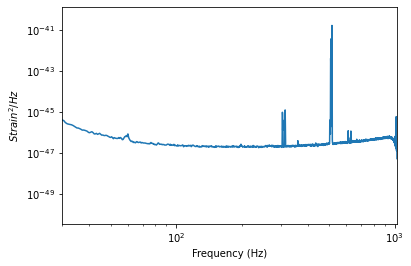

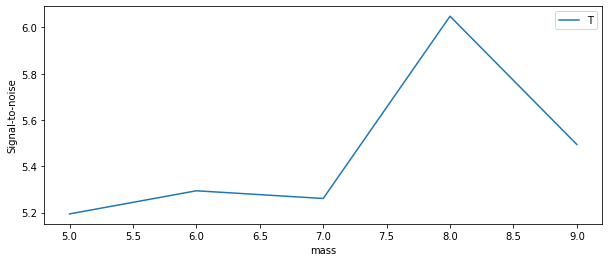

The optimal mass for a template was found to be 8.0 (in Solar masses)


In [ ]:
# Part 2: Plot the noise power spectral density PSD
# Estimate the power spectral density

# From: https://github.com/gwastro/PyCBC-Tutorials/blob/master/tutorial/3_WaveformMatchedFilter.ipynb


masses = np.arange(5.0, 10.0,1).tolist() # Mass range bewteen 5 to 10 Solar masses, 1 is a step (we assume equal mass binary systems)
data=strain['H1']
data_fd=stilde['H1']
snr_list_H1=[]
delta_t=dt[1]- dt[0]
dict_masses={}  # This dictionary stores SNR values corresponding to Solar masses from the given range
for m in masses:
  
  template=get_template(m, data, approximant="TaylorT2")
  psd=compute_psd(data, data_fd)
  snr=compute_snr(template, data, psd, low_frequency_cutoff=20)
  snr_list_H1.append(max(abs(snr)))
  dict_masses[m]=max(abs(snr))

# Plot PSD 
pylab.loglog(psd.sample_frequencies, psd)
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.xlim(30, 1024)

# Plot SNR vs Total Mass graph
pylab.figure(figsize=[10, 4])
pylab.plot(masses, snr_list_H1, label= 'H1')
pylab.legend('True')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

# Find the mass value producing the max SNR
peak = max(snr_list_H1)
optimal_mass = get_key_from_value(dict_masses, peak) # Find the template waveform for which snr is max
print("The optimal mass for a template was found to be {} (in Solar masses)".format(optimal_mass))


In [ ]:
# As we can see SNR crosses point 8 (8 Solar masses), therfore GW signal is detected

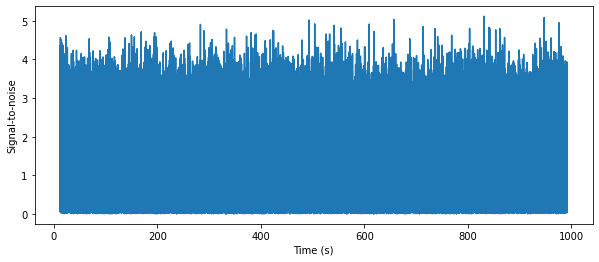

We found a signal at 831.43603515625s with SNR 5.1165829373752985


In [ ]:
# Find max SNR
conditioned=strain['H1']
data_fd=stilde['H1']
template=get_template(1.0, conditioned, approximant="TaylorT2") # We input mass=1.0 (in Solar massses)
psd=compute_psd(conditioned, data_fd)
snr=compute_snr(template, conditioned, psd, low_frequency_cutoff=20)
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

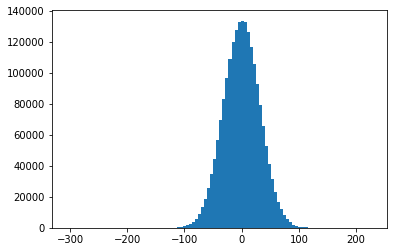

In [ ]:
# Part 2.2

import matplotlib.pyplot as plt
white_data = (conditioned.to_frequencyseries() / psd** 0.5 ).to_timeseries()

# trim the data to get rid of spikes at the boundaries
white_data=white_data.crop(4 + 4, 4)

# Plot the histogrM
plt.hist(white_data, bins=100)
plt.show()



In [ ]:
# As we can see the noise follows the Gaussian distribution (a 'bell' curve)

In [ ]:
# Part 2.3
from pycbc.filter import sigmasq

# Generate frequency domain waveform
hp, hc = get_fd_waveform(approximant="TaylorF2", mass1=3, mass2=3,
delta_f=1.0/(200.0), distance = 500, f_lower=20.0, f_final = 2048.0) #Luminosity distance = 500 Mpc

delta_t = strain['H1'].delta_t
seg_len = int(2 / delta_t)
seg_stride = int(seg_len / 2)
PSD=pycbc.psd.welch(strain['H1'], seg_len=seg_len, seg_stride=seg_stride) # Use Welch's method

SNR_values=[] # list storing SNR for every chunk of data
for psd in PSD:
  # Find the optimal SNR
  SNR = (np.sum((4*hp*np.conj(hp)*hp.delta_f/psd).data).real)**0.5

  SNR_values.append(SNR)




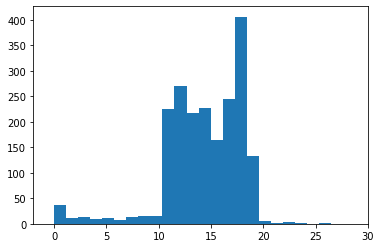

In [ ]:

# Plot the histogram   
plt.hist(SNR_values, bins=700)
plt.xlim(-2, 30)
plt.show()

In [ ]:
# The SNR tends to lie within region 10-22